In [1]:
# To be able to run this code you will need Cython installed (sudo pip install Cython)
# and to run the command
# python setup_dtw.py build_ext --inplace
# To compile the Cython library

In [2]:
%%bash
cd dtw
python setup_dtw.py build_ext --inplace

running build_ext


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import itertools

from dtw import dtw_distances, dtw
from dtw.plot import plot_alignment, plot_cost_matrix, plot_distances, plot_cost_matrices

In [4]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
np.set_printoptions(precision=3)


In [5]:
metrics = ['sqeuclidean','euclidean','cosine']
dtw_parameters = [
    {},
    {'constraint' : 'sakoe_chiba',  'frac' : 0.05},
    {'constraint' : 'sakoe_chiba',  'frac' : 0.1},
    {'constraint' : 'sakoe_chiba',  'frac' : 0.2},
    {'constraint' : 'slanted_band', 'frac' : 0.05},
    {'constraint' : 'slanted_band', 'frac' : 0.1},
    {'constraint' : 'slanted_band', 'frac' : 0.2},
    {'constraint' : 'itakura'},
]
labels = [
    'Unconstrained',
    'Sakoe Chiba 0.05',
    'Sakoe Chiba 0.1',
    'Sakoe Chiba 0.2',
    'Slanted Band 0.05',
    'Slanted Band 0.1',
    'Slanted Band 0.2',
    'Itakura Parallelogram'
]

In [6]:
lengths = np.array([100,200,500,1000,2000,5000])
y1 = [np.sin(2*np.pi*np.linspace(0,3,N)) for N in lengths]
y2 = [-0.15*np.cos(3*2*np.pi*np.linspace(0,3,N))+np.cos(2*np.pi*np.linspace(0,3,N)) for N in lengths]

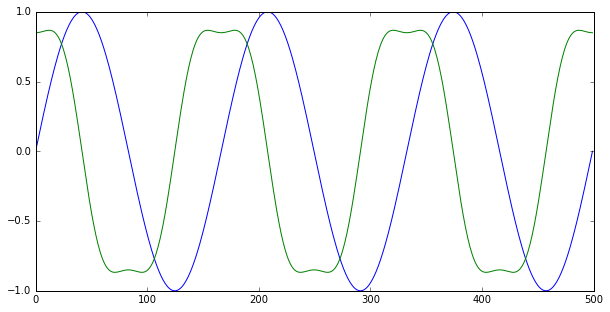

In [7]:
u,v = y1[2],y2[2]
plt.plot(u)
plt.plot(v)

# Unconstrained DTW
Naive version that computes all

57.678493179493444


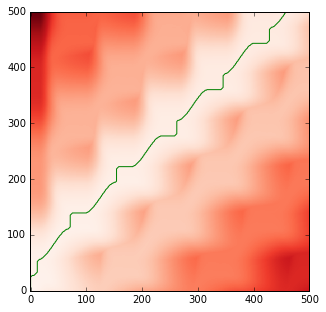

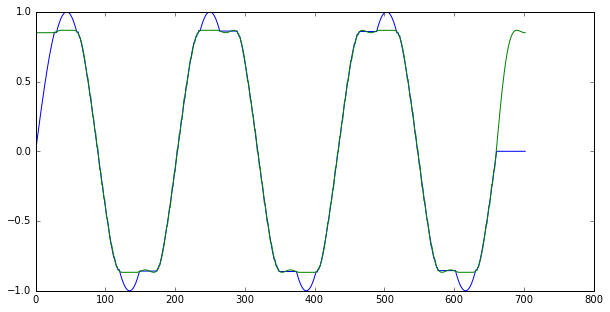

In [8]:
dist, cost_matrix, (alig_u, alig_v) = dtw(u,v,dist_only=False)
print(dist)
plt.plot(alig_v, alig_u,color='g')
plt.imshow(cost_matrix, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.figure()

plt.plot(u[alig_u])
plt.plot(v[alig_v])

# Sakoe-Chiba constraint
DTW constrained by Sakoe & Chiba band of width 2k+1.
       The warping path is constrained by |i-j| <= k
       
*[Sakoe78] H Sakoe, & S Chiba S. Dynamic programming algorithm optimization for spoken word recognition. Acoustics, 1978*

57.678493179493444


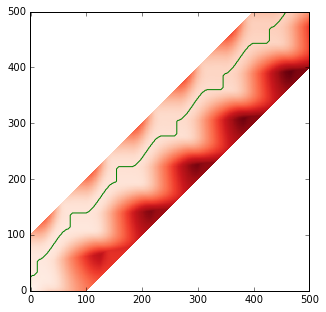

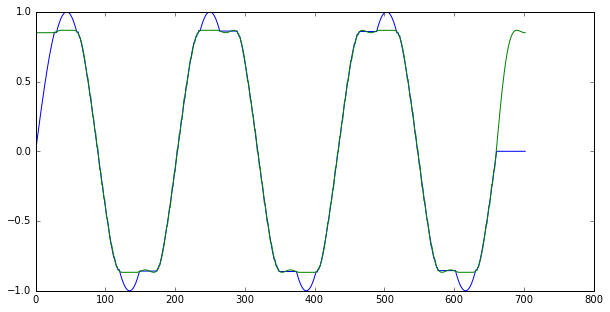

In [9]:
dist, cost_matrix, (alig_u, alig_v) = dtw(u,v,dist_only=False,constraint='sakoe_chiba',frac=0.2)
print(dist)
plt.plot(alig_v, alig_u,color='g')
plt.imshow(cost_matrix, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.figure()

plt.plot(u[alig_u])
plt.plot(v[alig_v])

# Itakura constraint
DTW constrained by Itakura Parallelogram
       
*[Itakura75] F Itakura. Minimum prediction residual principle applied to speech recognition. Acoustics, Speech and Signal Processing, IEEE Transactions on, 23(1), 67–72, 1975. doi:10.1109/TASSP.1975.1162641.*

85.41457669394255


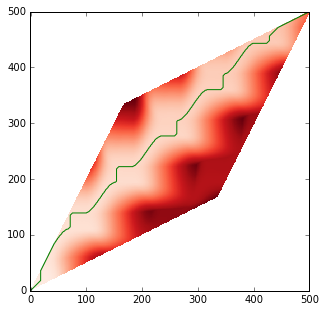

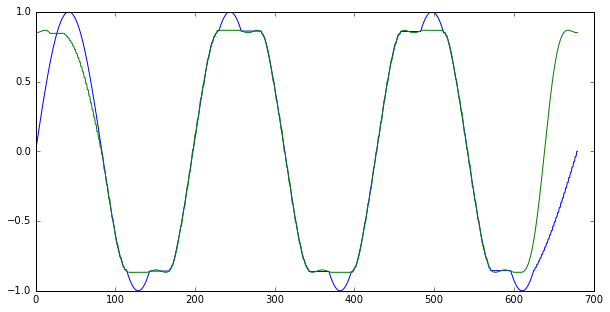

In [10]:
dist, cost_matrix, (alig_u, alig_v) = dtw(u,v,dist_only=False,constraint='itakura')
print(dist)
plt.plot(alig_v, alig_u,color='g')
plt.imshow(cost_matrix, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.figure()

plt.plot(u[alig_u])
plt.plot(v[alig_v])

# Timimg
For lengths below 10000 the algorithm performs below under a second, outperforming any pure Python Implementation


In [11]:
try:
    from tqdm import tqdm_notebook
except:
    def tqdm_notebook(x,**kwargs):
        return x
it = 10
times = np.zeros([len(lengths),len(labels)])
for i,kwargs in tqdm_notebook(enumerate(dtw_parameters),desc='constraint',total=len(dtw_parameters)):
    times[:,i] = np.array([timeit.Timer("dtw(y1[%d],y2[%d],**kwargs)" % (i,i), \
                           setup="from __main__ import dtw,y1,y2,kwargs").timeit(number=it)/it \
                           for i,_ in tqdm_notebook(enumerate(y1),desc='lengths',leave=False,total=len(y1))])


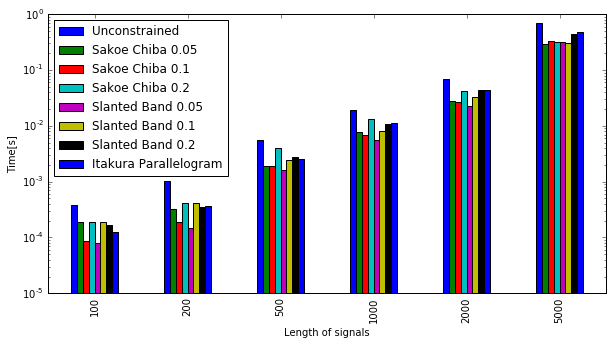

In [12]:
df_times = pd.DataFrame(times,columns=labels,index=lengths)
df_times.plot.bar(logy=True)
plt.xlabel('Length of signals')
plt.ylabel('Time[s]')

# Pairwise DTW 

Sometimes we need pairwise DTW fot a large number of time series

## dtw_distaces
Allows for fast parallel computation of pairwise DTW distances between signals.

*Requires Python 3*

In [13]:
# Some harmonic approximations of Square Wave
long_sigs = [ np.sum(np.array([ 1/j*np.sin(2*np.pi*j*np.linspace(0,1,2500)) for j in range(1,i+1,2) ]),axis=0) for i in range(1,21,2)]

In [14]:
dtw_distances(long_sigs)

array([[   0.   ,  125.949,  134.025,  129.273,  122.887,  117.021,
         111.906,  107.598,  103.938,  100.867],
       [ 125.949,    0.   ,   52.879,   66.027,   69.329,   69.341,
          68.419,   66.991,   65.506,   64.012],
       [ 134.025,   52.879,    0.   ,   29.722,   40.594,   45.192,
          47.074,   47.732,   47.601,   47.458],
       [ 129.273,   66.027,   29.722,    0.   ,   19.368,   27.957,
          32.366,   34.724,   35.981,   36.629],
       [ 122.887,   69.329,   40.594,   19.368,    0.   ,   13.867,
          20.68 ,   24.637,   26.982,   28.457],
       [ 117.021,   69.341,   45.192,   27.957,   13.867,    0.   ,
          10.614,   16.108,   19.532,   21.743],
       [ 111.906,   68.419,   47.074,   32.366,   20.68 ,   10.614,
           0.   ,    8.523,   13.021,   16.034],
       [ 107.598,   66.991,   47.732,   34.724,   24.637,   16.108,
           8.523,    0.   ,    7.144,   10.869],
       [ 103.938,   65.506,   47.601,   35.981,   26.982,   19.5

In [15]:
dtw_distances(long_sigs,n_jobs=2)

array([[   0.   ,  125.949,  134.025,  129.273,  122.887,  117.021,
         111.906,  107.598,  103.938,  100.867],
       [ 125.949,    0.   ,   52.879,   66.027,   69.329,   69.341,
          68.419,   66.991,   65.506,   64.012],
       [ 134.025,   52.879,    0.   ,   29.722,   40.594,   45.192,
          47.074,   47.732,   47.601,   47.458],
       [ 129.273,   66.027,   29.722,    0.   ,   19.368,   27.957,
          32.366,   34.724,   35.981,   36.629],
       [ 122.887,   69.329,   40.594,   19.368,    0.   ,   13.867,
          20.68 ,   24.637,   26.982,   28.457],
       [ 117.021,   69.341,   45.192,   27.957,   13.867,    0.   ,
          10.614,   16.108,   19.532,   21.743],
       [ 111.906,   68.419,   47.074,   32.366,   20.68 ,   10.614,
           0.   ,    8.523,   13.021,   16.034],
       [ 107.598,   66.991,   47.732,   34.724,   24.637,   16.108,
           8.523,    0.   ,    7.144,   10.869],
       [ 103.938,   65.506,   47.601,   35.981,   26.982,   19.5

In [16]:
long_sigs = [ np.sum(np.array([ 1/j*np.sin(2*np.pi*j*np.linspace(0,1,2500)) for j in range(1,i+1,2) ]),axis=0) for i in range(1,21,2)]
it = 1
n_procs = [1,2,4,-1]
times = np.zeros([len(n_procs),len(labels)])
for i,kwargs in tqdm_notebook(enumerate(dtw_parameters),total=len(dtw_parameters),desc='constraint'):
    times[:,i] = np.array([timeit.Timer("dtw_distances(long_sigs,n_jobs=%d,**kwargs)" % (n), \
                           setup="from __main__ import dtw_distances,long_sigs,kwargs").timeit(number=it)/it \
                           for n in tqdm_notebook(n_procs,desc='n_proc',leave=False)])


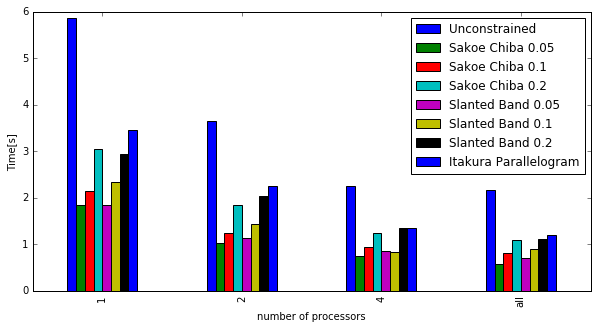

In [17]:
df_times = pd.DataFrame(times,columns=labels,index=n_procs[:-1]+['all'])
df_times.plot.bar()
plt.xlabel('number of processors')
plt.ylabel('Time[s]')

# Plotting

Even though $DTW(x,y)$ returns real valued distance, a large part of using DTW as a distance metric consists of visualizing the warped signals and the produced aligment



In [18]:
sigs = [ np.sum(np.array([ 1/j*np.sin(2*np.pi*j*np.linspace(0,1)) for j in range(1,i+1,2) ]),axis=0) for i in range(1,13,2)]
sigs = [np.sin(2*np.pi*np.linspace(0,1)+1)]+sigs
u,v = sigs[2],sigs[5]

## plot_aligment
Visualizes the resulting temporal alignment obtained by the DTW computation

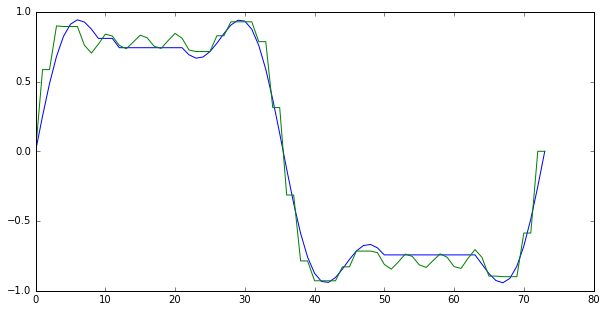

In [19]:
fig = plot_alignment(u,v,normalize=True,constraint='itakura')

## plot_dtw_cost_matrix
Plots the cost matrix along with the signals that are being aligned in the corresponding axes

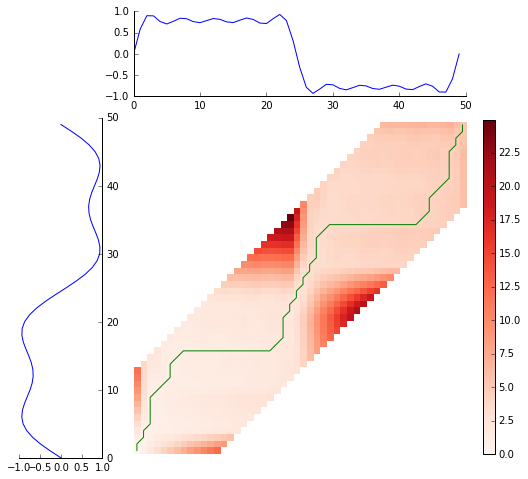

In [20]:
fig = plot_cost_matrix(u,v,normalize=True,constraint='sakoe_chiba',frac=0.25,axis=True)

## plot_dtw_distances
Visualice DTW distance matrix of a number of signals

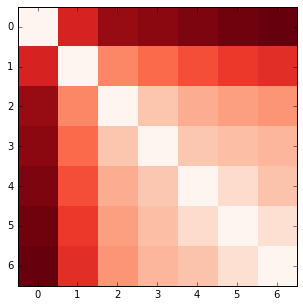

In [21]:
fig = plot_distances(sigs,normalize=True,constraint='sakoe_chiba',frac=0.25)

## plot_dtw_cost_matrices
Good visualization tool for easily looking at pairwise DTW matrices for a number of signals

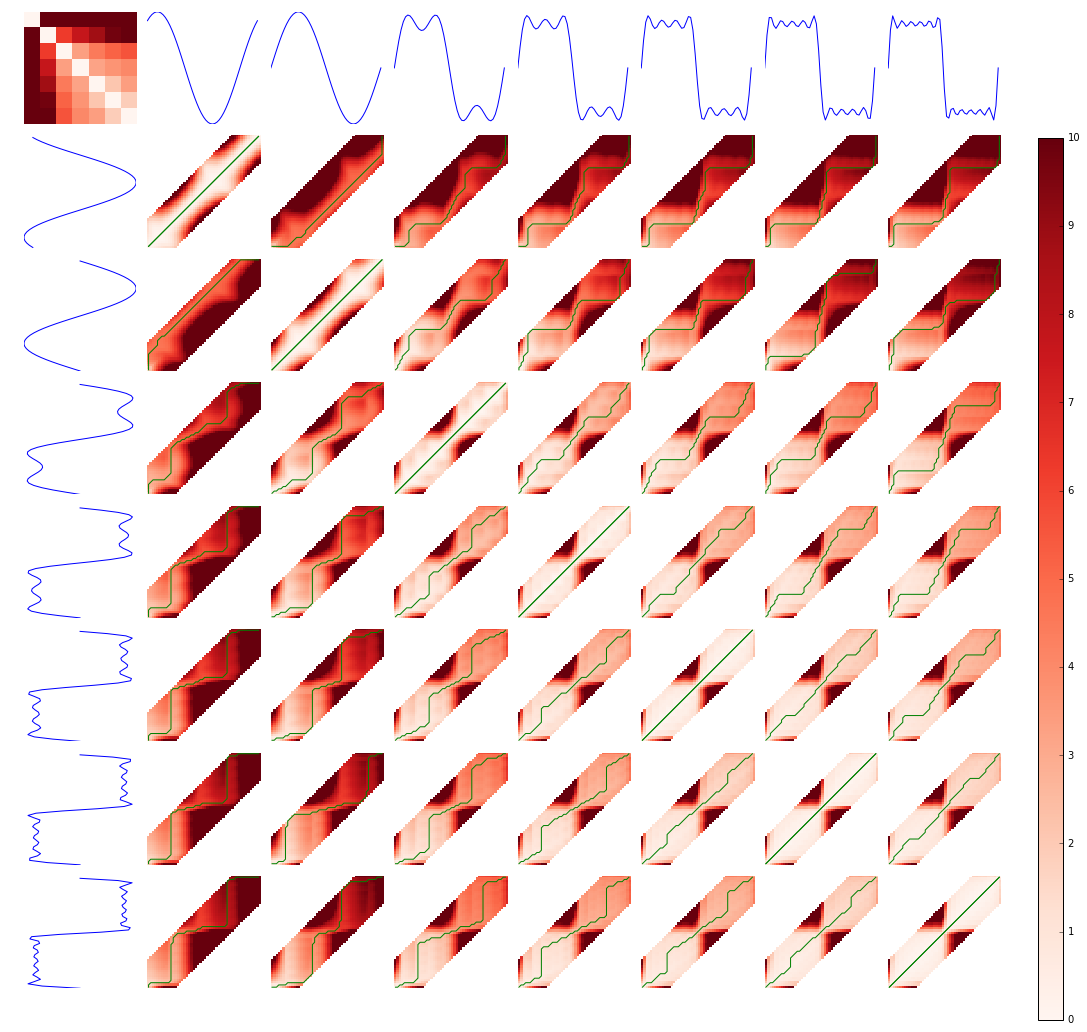

In [22]:
fig = plot_cost_matrices(sigs,normalize=True,constraint='sakoe_chiba',frac=0.25,vmax=10)